# Data challenge 3 second project

In [155]:
import pickle
import os
import sys
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1.Data Preparation 

This section includes loading and preprocessing the dataset, load the papers data and extract the features from the txt file

In [156]:
import pandas as pd

# Function to parse the papers.txt file and create a DataFrame
def parse_papers(file_path):
    # Read the content of the file
    with open(file_path, "r", encoding='utf-8') as file:
        data = file.read()
    
    # Split the data by paper blocks (separated by two newlines or '#*')
    paper_blocks = data.strip().split("\n\n")

    papers = []
    for block in paper_blocks:
        paper_data = {}
        lines = block.split("\n")
        
        for line in lines:
            # Title: line starts with '#*'
            if line.startswith("#*"):
                paper_data["title"] = line[2:].strip()
            # Authors: line starts with '#@'
            elif line.startswith("#@"):
                paper_data["authors"] = line[2:].strip()
            # Year: line starts with '#t'
            elif line.startswith("#t"):
                paper_data["year"] = line[2:].strip()
            # Citations: line starts with '#c'
            elif line.startswith("#c"):
                paper_data["citations"] = line[2:].strip()
            # Index: line starts with '#index'
            elif line.startswith("#index"):
                paper_data["index"] = line[6:].strip()
            # Additional comments or description (optional): lines starting with '#!' (can be ignored for the DataFrame)
            elif line.startswith("#!"):
                continue
        
        papers.append(paper_data)

    # Convert the list of papers into a DataFrame
    df = pd.DataFrame(papers)
    return df

# Path to the file
file_path = "Data/papers.txt" 

# Parse the data and create a DataFrame
df = parse_papers(file_path)

In [157]:
df = pd.read_csv('Data/papers_.csv')

In [158]:
df.shape

(629814, 7)

---

#### 1.1 Data cleaning

In [159]:
df['index'] = df['index'].astype(str)

In [160]:
# import the picke file 
with open('Data/pid_cat_dict.pkl', 'rb') as file:
    picke_df = pickle.load(file)

picke_df = pd.DataFrame(picke_df.items(), columns=['index', 'categories'])

#  Merge the two dataframes
df = df.merge(picke_df, on='index', how='left')

In [161]:
picke_df.head(5)

,index,categories
0,0,"[13, 18]"
1,1,"[18, 25]"
2,2,"[6, 11]"
3,3,[18]
4,4,"[17, 19]"


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629814 entries, 0 to 629813
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   title       629814 non-null  object
 1   authors     603898 non-null  object
 2   year        629814 non-null  int64 
 3   venue       531220 non-null  object
 4   index       629814 non-null  object
 5   citations   125372 non-null  object
 6   abstract    281080 non-null  object
 7   categories  629814 non-null  object
dtypes: int64(1), object(7)
memory usage: 38.4+ MB


In [163]:
df.head(5)

,title,authors,year,venue,index,citations,abstract,categories
0,Automated Deduction in Geometry: 5th Internati...,"Hoon Hong,Dongming Wang",2006,NaN,0,NaN,NaN,"[13, 18]"
1,A+ Certification Core Hardware (Text & Lab Man...,Charles J. Brooks,2003,NaN,1,NaN,NaN,"[18, 25]"
2,Performance engineering in industry: current p...,"Ahmed E. Hassan,Parminder Flora",2007,Proceedings of the 6th international workshop ...,2,NaN,This panel session discusses performance engin...,"[6, 11]"
3,"Dude, You Can Do It! How to Build a Sweeet PC","Darrel Creacy,Carlito Vicencio",2005,NaN,3,NaN,Whether you're frustrated with current PC offe...,[18]
4,What Every Programmer Needs to Know about Secu...,"Neil Daswani,Anita Kesavan",2006,NaN,4,NaN,NaN,"[17, 19]"


In [164]:
len(df[df['citations'].notnull()])

125372

Out of 629814 papers, 125372 have null citations

In [165]:
df[df['citations'].notnull() & df['venue'].isnull()]

,title,authors,year,venue,index,citations,abstract,categories
588028,201 principles of software development,Alan M. Davis,1995,NaN,588028,164122;206639;510740;520097,From the Preface If software engineering is re...,"[8, 10]"
619912,The architecture of concurrent programs,Per Brinch Hansen,1977,NaN,619912,240173;322192;327623;332514;335280,From the Preface CONCURRENT PROGRAMMING This b...,[22]


This suggests that every paper with citations in the dataset also has venue information (except for two papers).


This is logical because academic papers that cite other works are typically formal publications (e.g., journal articles, conference papers), and formal publications almost always have venue details. Papers without venue details might be drafts, unpublished works, or non-traditional outputs that don't cite other papers in the dataset.

---

#### 1.2 Encoding

One-hot encoded category feature

In [166]:
categories_flat = [category for sublist in df['categories'] for category in sublist]
unique_categories = sorted(set(categories_flat))

for category in unique_categories:
    df[f'category_{category}'] = df['categories'].apply(lambda x: 1 if category in x else 0)

In [167]:
(df['authors'])

0                                  Hoon Hong,Dongming Wang
1                                        Charles J. Brooks
2                          Ahmed E. Hassan,Parminder Flora
3                           Darrel Creacy,Carlito Vicencio
4                               Neil Daswani,Anita Kesavan
                                ...                       
629809                                                 NaN
629810                                                 NaN
629811             Manolis Perakakis,Alexandros Potamianos
629812                                          V. K. Jain
629813    Maryam Shokri,Hamid R. Tizhoosh,Mohamed S. Kamel
Name: authors, Length: 629814, dtype: object

In [168]:
# fillna with '' for authors
df['authors'] = df['authors'].fillna('')

# give the rows which have empty authors
df['authors_list'] = df['authors'].apply(lambda x: [author.strip() for author in x.split(",")])

# Step 2: Check for empty authors
empty_authors_df = df[df['authors_list'].apply(lambda x: any(not author for author in x))]

This shows that only 290 papers without author had citations

In [169]:
empty_authors_df[empty_authors_df['citations'].notnull()].shape

(290, 44)

In [170]:
# sort df by year
df = df.sort_values(by='year', ascending=True)

In [171]:
len(df[df['year'] == '-1'])

0

In [172]:
# check for empty authors
len(df[df['authors'] == ''])

25916

In [173]:
len(df[df['venue'].isnull()])

98594

In [174]:
df[df['title'].isnull()]

,title,authors,year,venue,index,citations,abstract,categories,category_0,category_1,...,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34,authors_list


In [175]:
# check for nan 
df.isna().sum()

title                0
authors              0
year                 0
venue            98594
index                0
citations       504442
abstract        348734
categories           0
category_0           0
category_1           0
category_2           0
category_3           0
category_4           0
category_5           0
category_6           0
category_7           0
category_8           0
category_9           0
category_10          0
category_11          0
category_12          0
category_13          0
category_14          0
category_15          0
category_16          0
category_17          0
category_18          0
category_19          0
category_20          0
category_21          0
category_22          0
category_23          0
category_24          0
category_25          0
category_26          0
category_27          0
category_28          0
category_29          0
category_30          0
category_31          0
category_32          0
category_33          0
category_34          0
authors_lis

In [176]:
# extract the index of each of the paper with no year
papers_without_year_index = df[df['year'] == '-1']['index'].tolist()
# iterate through the papers without year and extract the number of papers which cite them and save in a dataframe
papers_without_year_citations = []
for index in papers_without_year_index:
    papers_without_year_citations.append(df[df['citations'].notnull() & df['citations'].str.contains(index)].shape[0])

papers_without_year_citations_df = pd.DataFrame({'index': papers_without_year_index, 'citations': papers_without_year_citations})

In [177]:
papers_without_year_citations_df

,index,citations


In [178]:
type(df['year'][10])
# transfom the year column to int
df['year'] = df['year'].apply(lambda x: int(x) if x != '-1' else -1)

In [179]:
def display_for_index(index, ls_columns=None):
    if ls_columns:
        display(df[df['index'] == index][ls_columns])
    else:
        display(df[df['index'] == index])

In [180]:
display_for_index('3640')
df.loc[df['index'] == '3640', 'year'] = 2006
display_for_index('3640')

,title,authors,year,venue,index,citations,abstract,categories,category_0,category_1,...,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34,authors_list
3640,Digital Reference,Linda Berube,-1,NaN,3640,NaN,NaN,[15],0,0,...,0,0,0,0,0,0,0,0,0,[Linda Berube]


,title,authors,year,venue,index,citations,abstract,categories,category_0,category_1,...,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34,authors_list
3640,Digital Reference,Linda Berube,2006,NaN,3640,NaN,NaN,[15],0,0,...,0,0,0,0,0,0,0,0,0,[Linda Berube]


In [181]:
display_for_index('57929', ['title', 'year'])
df.loc[df['index'] == '57929', 'year'] = 2008
display_for_index('57929')

,title,year
57929,Proceedings of the 15th International Conferen...,-1


,title,authors,year,venue,index,citations,abstract,categories,category_0,category_1,...,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34,authors_list
57929,Proceedings of the 15th International Conferen...,,2008,Lecture Notes In Computer Science; Vol. 5374,57929,NaN,NaN,[34],0,0,...,0,0,0,0,0,0,0,0,1,[]


In [182]:
df.drop(df[df['year'] == -1].index, inplace=True)
df.drop(columns=['categories'], inplace=True)

In [183]:
df.drop(columns=['authors_list'], inplace=True)
df.drop(columns=['authors'], inplace=True)

In [184]:
df['venue'] = df['venue'].apply(lambda x: 1 if x else 0)

In [185]:
#df.to_pickle('Data/preprocessed_df.pkl')

In [186]:
display(df.head(5)), df.shape

,title,year,venue,index,citations,abstract,category_0,category_1,category_2,category_3,...,category_25,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34
57929,Proceedings of the 15th International Conferen...,2008,1,57929,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3640,Digital Reference,2006,1,3640,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
447127,Freenet P,1900,1,447127,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
192455,A linear algebraic theory of complexes,1941,1,192455,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185904,The embedding of products and joins of complex...,1947,1,185904,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(None, (629807, 41))


### 2. **Generate Citation Pairs**
Create positive and negative pairs for training and testing.
create a dataset of `(paper_a, paper_b, label)` where `label = 1` if `paper_a` cites `paper_b` and `0` otherwise.

In [187]:
# fill all the nan values with 0
df.fillna('', inplace=True)

In [188]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# Split the data by paper indices, ensuring balanced class distribution (stratify)
def split_data_balanced(df, test_size=0.2):
    # Create a label column for stratification (0 = no citations, 1 = citations)
    df['label'] = df['citations'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)

    # Split the dataset while maintaining the class distribution (stratify by 'label')
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=55)
    
    return train_df, test_df

# Optimized function to create positive pairs
def create_positive_pairs(df, max_positive):
    pairs = []
    indices_set = set(df['index'].values)

    for _, row in df.iterrows():
        if len(pairs) >= max_positive:
            break
        citing_paper = row['index']
        cited_papers = row['citations'].split(';') if row['citations'] else []
        valid_cited_papers = [cited for cited in cited_papers if cited in indices_set]
        
        for cited in valid_cited_papers:
            if len(pairs) >= max_positive:
                break
            pairs.append((citing_paper, cited, 1))

    return pairs

# Optimized function to create negative pairs
def create_negative_pairs(df, max_negative, num_negatives=2):
    pairs = []
    indices = df['index'].tolist()
    indices_set = set(indices)
    
    while len(pairs) < max_negative:
        citing_paper = random.choice(indices)
        negative_samples = random.sample(indices, num_negatives)
        
        for neg in negative_samples:
            if len(pairs) >= max_negative:
                break
            if neg != citing_paper and neg in indices_set:
                pairs.append((citing_paper, neg, 0))
    
    return pairs

# Parameters
max_pairs_train = 100000
max_positive_train = max_pairs_train // 2
max_negative_train = max_pairs_train - max_positive_train

max_pairs_test = 20000
max_positive_test = max_pairs_test // 2
max_negative_test = max_pairs_test - max_positive_test
# Example dataset split with balanced classes in train and test sets
train_df, test_df = split_data_balanced(df, test_size=0.2)
print(f"Training set: {len(train_df)} papers, {train_df['label'].sum()} citations")
print(f"Testing set: {len(test_df)} papers, {test_df['label'].sum()} citations")
# Generate positive and negative pairs for training, ensuring only training papers are used
train_positive_pairs = create_positive_pairs(train_df, max_positive_train)
train_negative_pairs = create_negative_pairs(train_df, max_negative_train, num_negatives=2)
train_pairs = train_positive_pairs + train_negative_pairs
random.shuffle(train_pairs)

# Generate positive and negative pairs for testing, ensuring only test papers are used
test_positive_pairs = create_positive_pairs(test_df, max_positive_test)
test_negative_pairs = create_negative_pairs(test_df, max_negative_test, num_negatives=2)
test_pairs = test_positive_pairs + test_negative_pairs
random.shuffle(test_pairs)

# Convert to DataFrames
train_pairs_df = pd.DataFrame(train_pairs, columns=['paper_a', 'paper_b', 'label'])
test_pairs_df = pd.DataFrame(test_pairs, columns=['paper_a', 'paper_b', 'label'])

# Check distribution
print(f"Training pairs: {len(train_pairs_df)} (Positive: {len([p for p in train_pairs if p[2] == 1])}, Negative: {len([p for p in train_pairs if p[2] == 0])})")
print(f"Testing pairs: {len(test_pairs_df)} (Positive: {len([p for p in test_pairs if p[2] == 1])}, Negative: {len([p for p in test_pairs if p[2] == 0])})")

Training set: 503845 papers, 100297 citations
Testing set: 125962 papers, 25075 citations
Training pairs: 100000 (Positive: 50000, Negative: 50000)
Testing pairs: 20000 (Positive: 10000, Negative: 10000)


This procedure first divides the dataset of paper indices into training and testing sets while maintaining a balanced class distribution based on whether papers have citations. After splitting, it uses these sets to create labeled pairs of papers: positive pairs (where one paper cites the other) and negative pairs (randomly paired papers without citation). This ensures the pairs are generated separately for training and testing, preserving data integrity.

In [189]:
train_pairs_df

,paper_a,paper_b,label
0,563462,311306,0
1,24,8161,0
2,138062,363780,0
3,469118,471134,0
4,354667,378469,0
...,...,...,...
99995,291220,350353,0
99996,87107,584454,1
99997,25859,325328,0
99998,497040,446168,1


In [190]:
test_pairs_df

,paper_a,paper_b,label
0,413734,624808,1
1,451321,485424,0
2,84022,108333,0
3,300514,530093,1
4,76997,374102,1
...,...,...,...
19995,461019,181031,1
19996,345364,620780,1
19997,381284,39594,0
19998,550416,320912,1


In [192]:
#train_pairs_df.to_pickle('Data/train_pairs_df.pkl')
#test_pairs_df.to_pickle('Data/test_pairs_df.pkl')

In [193]:
#train_pairs_df = pd.read_pickle('Data/train_pairs_df.pkl')
#test_pairs_df = pd.read_pickle('Data/test_pairs_df.pkl')
#df = pd.read_pickle('Data/preprocessed_df.pkl')

---

### 3. **Feature Engineering**

For each pair `(paper_a, paper_b)`, generate features:


In [194]:
df.columns

Index(['title', 'year', 'venue', 'index', 'citations', 'abstract',
       'category_0', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'category_6', 'category_7', 'category_8', 'category_9',
       'category_10', 'category_11', 'category_12', 'category_13',
       'category_14', 'category_15', 'category_16', 'category_17',
       'category_18', 'category_19', 'category_20', 'category_21',
       'category_22', 'category_23', 'category_24', 'category_25',
       'category_26', 'category_27', 'category_28', 'category_29',
       'category_30', 'category_31', 'category_32', 'category_33',
       'category_34', 'label'],
      dtype='object')

prendi n papers tra cui quello da predirre e dai attraverso gli embeddings quale è il più probabile che citi

In [195]:
# Merge to get features for paper_a
merged_a = train_pairs_df.merge(df, left_on='paper_a', right_on='index', suffixes=('', '_a'))
# Merge to get features for paper_b
merged_ab = merged_a.merge(df, left_on='paper_b', right_on='index', suffixes=('', '_b'))

In [196]:
display(merged_a.columns)
merged_ab.columns

Index(['paper_a', 'paper_b', 'label', 'title', 'year', 'venue', 'index',
       'citations', 'abstract', 'category_0', 'category_1', 'category_2',
       'category_3', 'category_4', 'category_5', 'category_6', 'category_7',
       'category_8', 'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'category_17', 'category_18', 'category_19', 'category_20',
       'category_21', 'category_22', 'category_23', 'category_24',
       'category_25', 'category_26', 'category_27', 'category_28',
       'category_29', 'category_30', 'category_31', 'category_32',
       'category_33', 'category_34', 'label_a'],
      dtype='object')

Index(['paper_a', 'paper_b', 'label', 'title', 'year', 'venue', 'index',
       'citations', 'abstract', 'category_0', 'category_1', 'category_2',
       'category_3', 'category_4', 'category_5', 'category_6', 'category_7',
       'category_8', 'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'category_17', 'category_18', 'category_19', 'category_20',
       'category_21', 'category_22', 'category_23', 'category_24',
       'category_25', 'category_26', 'category_27', 'category_28',
       'category_29', 'category_30', 'category_31', 'category_32',
       'category_33', 'category_34', 'label_a', 'title_b', 'year_b', 'venue_b',
       'index_b', 'citations_b', 'abstract_b', 'category_0_b', 'category_1_b',
       'category_2_b', 'category_3_b', 'category_4_b', 'category_5_b',
       'category_6_b', 'category_7_b', 'category_8_b', 'category_9_b',
       'category_10_b', 'category_11_b', 'category_12_b', 'c

In [197]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def prepare_features(pairs_df, df, fit_tfidf=False, tfidf_vectorizer=None):
    # Merge pairs_df with df to get features for paper_a
    merged_a = pairs_df.merge(df, left_on='paper_a', right_on='index', suffixes=('', '_a'))
    merged_ab = merged_a.merge(df, left_on='paper_b', right_on='index', suffixes=('', '_b'))

    # Combine the titles for comparison
    titles_a = merged_ab['title'].fillna('')  # Handle missing titles in paper_a
    titles_b = merged_ab['title_b'].fillna('')  # Handle missing titles in paper_b

    if fit_tfidf:
        # If fit_tfidf is True, fit the TF-IDF vectorizer on the titles of the training set
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_vectorizer.fit(titles_a)
    
    # Transform titles_a and titles_b using the same fitted tfidf_vectorizer
    tfidf_matrix_a = tfidf_vectorizer.transform(titles_a)
    tfidf_matrix_b = tfidf_vectorizer.transform(titles_b)

    # Compute pairwise cosine similarity for aligned pairs
    title_similarity = [cosine_similarity(tfidf_matrix_a[i], tfidf_matrix_b[i])[0][0] for i in range(tfidf_matrix_a.shape[0])]

    # Assign title similarity scores to the merged DataFrame
    merged_ab['title_similarity'] = title_similarity

    # Select features for model (same as in the original implementation)
    features = merged_ab.drop(columns=['citations', 'citations_b', 'index', 'index_b', 'paper_a', 'paper_b', 'label', 'title', 'title_b', 'abstract', 'abstract_b'])

    # Extract labels if they exist in the pairs DataFrame
    if 'label' in merged_ab.columns:
        labels = merged_ab['label']
    else:
        labels = None  # For test set or when labels are missing

    return features, labels, tfidf_vectorizer, merged_ab

# Example usage for train set:
train_features, train_labels, tfidf_vectorizer, merged_ab_train = prepare_features(train_pairs_df, df, fit_tfidf=True)

# Example usage for test set:
test_features, test_labels, _, merged_ab_test = prepare_features(test_pairs_df, df, fit_tfidf=False, tfidf_vectorizer=tfidf_vectorizer)

In [198]:
display(train_features.head())
display(train_labels.head())

,year,venue,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,...,category_27_b,category_28_b,category_29_b,category_30_b,category_31_b,category_32_b,category_33_b,category_34_b,label_b,title_similarity
0,2002,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.137211
1,2006,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.015544
2,2009,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,1989,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.032519
4,2009,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [199]:
train_features.columns

Index(['year', 'venue', 'category_0', 'category_1', 'category_2', 'category_3',
       'category_4', 'category_5', 'category_6', 'category_7', 'category_8',
       'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'category_17', 'category_18', 'category_19', 'category_20',
       'category_21', 'category_22', 'category_23', 'category_24',
       'category_25', 'category_26', 'category_27', 'category_28',
       'category_29', 'category_30', 'category_31', 'category_32',
       'category_33', 'category_34', 'label_a', 'year_b', 'venue_b',
       'category_0_b', 'category_1_b', 'category_2_b', 'category_3_b',
       'category_4_b', 'category_5_b', 'category_6_b', 'category_7_b',
       'category_8_b', 'category_9_b', 'category_10_b', 'category_11_b',
       'category_12_b', 'category_13_b', 'category_14_b', 'category_15_b',
       'category_16_b', 'category_17_b', 'category_18_b', 'category_19_b',
       '

In [218]:
#merged_ab_train.to_pickle('Data/train_dataset_title_sim.pkl')
#merged_ab_test.to_pickle('Data/test_dataset_title_sim.pkl')
train_data = merged_ab_train.copy()
test_data = merged_ab_test.copy()

`Feature engineering procedure has been done in the other notebooks more in details`

### 4. **Prepare Data for Training**

In [219]:
from sklearn.preprocessing import StandardScaler

#train_data = pd.read_pickle('Data/train_dataset_title_sim.pkl')
#test_data = pd.read_pickle('Data/test_dataset_title_sim.pkl')

X_train_raw = train_data.drop(columns=['title', 'title_b', 'abstract', 'abstract_b', 'citations', 'citations_b', 'index', 'index_b', 'label'])
y_train = train_data['label']
X_test_raw = test_data.drop(columns=['title', 'title_b', 'abstract', 'abstract_b', 'citations', 'citations_b', 'index', 'index_b', 'label'])
y_test = test_data['label']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_train = pd.DataFrame(X_train, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test, columns=X_test_raw.columns)

Performed features scaling using Standardscaler (in this case was not really necessary because Random Forests are based on decision trees, which split data based on feature thresholds rather than calculating distances or gradients).

In [220]:
y_train.value_counts()

label
0    50000
1    50000
Name: count, dtype: int64

In [221]:
y_test.value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

- Feature Correlation Matrix

Identifying Relationships Between Features and the Target Variable to Improve Model Performance and Interpretability

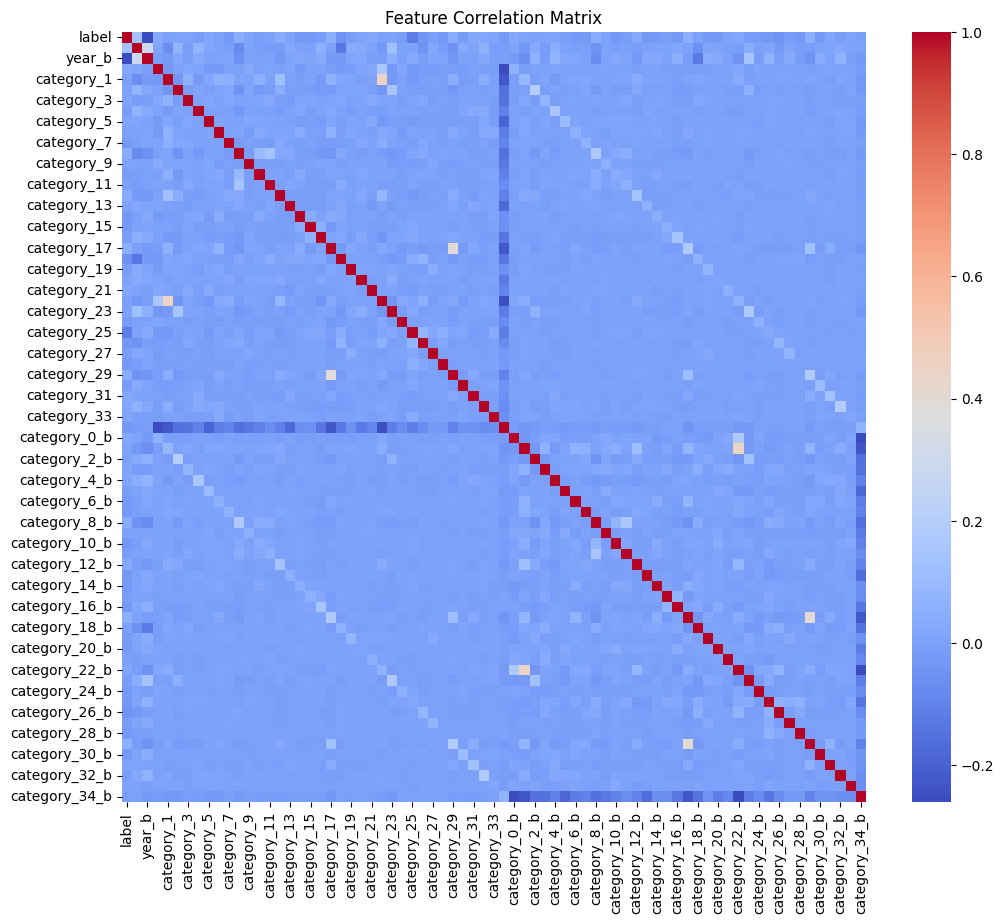

In [222]:
import seaborn as sns
correlation_features = train_data[['label', 'year', 'year_b'] + 
                                  [f'category_{i}' for i in range(35)] +
                                  [f'category_{i}_b' for i in range(35)]]

# Compute the correlation matrix
correlation_matrix = correlation_features.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [223]:
correlation_matrix['label'].sort_values(ascending=False)

label            1.000000
year             0.136766
category_17      0.059758
category_17_b    0.056547
category_29_b    0.054628
                   ...   
category_26     -0.038343
category_18     -0.043591
category_26_b   -0.044798
category_25     -0.114108
year_b          -0.257220
Name: label, Length: 73, dtype: float64

In [224]:
y_train.head(5)

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

### 5. **Train a Model**

Random Forest model trainign procedure:

In [225]:
X_train.head(5)

,paper_a,paper_b,year,venue,category_0,category_1,category_2,category_3,category_4,category_5,...,category_27_b,category_28_b,category_29_b,category_30_b,category_31_b,category_32_b,category_33_b,category_34_b,label_b,title_similarity
0,1.348769,-0.089376,0.400971,0.0,2.367124,-0.374032,-0.24902,-0.235438,-0.169007,3.224486,...,-0.038759,-0.034806,-0.164509,-0.068938,-0.084921,-0.097517,-0.094008,-0.620935,1.385781,0.610439
1,-1.677500,-1.803036,0.867315,0.0,-0.422454,-0.374032,-0.24902,-0.235438,-0.169007,3.224486,...,-0.038759,-0.034806,-0.164509,-0.068938,-0.084921,-0.097517,-0.094008,-0.620935,1.385781,-0.376518
2,-0.936087,0.207256,1.217073,0.0,-0.422454,-0.374032,-0.24902,-0.235438,-0.169007,-0.310127,...,-0.038759,-0.034806,-0.164509,-0.068938,-0.084921,-0.097517,-0.094008,-0.620935,-0.721615,-0.502607
3,0.842040,0.814121,-1.114647,0.0,-0.422454,-0.374032,-0.24902,-0.235438,-0.169007,-0.310127,...,-0.038759,-0.034806,-0.164509,-0.068938,-0.084921,-0.097517,-0.094008,-0.620935,-0.721615,-0.238814
4,0.227315,0.290292,1.217073,0.0,-0.422454,-0.374032,-0.24902,-0.235438,-0.169007,-0.310127,...,-0.038759,-0.034806,-0.164509,-0.068938,-0.084921,-0.097517,-0.094008,-0.620935,-0.721615,-0.502607


In [226]:
X_train.columns

Index(['paper_a', 'paper_b', 'year', 'venue', 'category_0', 'category_1',
       'category_2', 'category_3', 'category_4', 'category_5', 'category_6',
       'category_7', 'category_8', 'category_9', 'category_10', 'category_11',
       'category_12', 'category_13', 'category_14', 'category_15',
       'category_16', 'category_17', 'category_18', 'category_19',
       'category_20', 'category_21', 'category_22', 'category_23',
       'category_24', 'category_25', 'category_26', 'category_27',
       'category_28', 'category_29', 'category_30', 'category_31',
       'category_32', 'category_33', 'category_34', 'label_a', 'year_b',
       'venue_b', 'category_0_b', 'category_1_b', 'category_2_b',
       'category_3_b', 'category_4_b', 'category_5_b', 'category_6_b',
       'category_7_b', 'category_8_b', 'category_9_b', 'category_10_b',
       'category_11_b', 'category_12_b', 'category_13_b', 'category_14_b',
       'category_15_b', 'category_16_b', 'category_17_b', 'category_18_b',
   

In [227]:
X_train = X_train.drop(columns=['paper_a', 'paper_b'])
X_test = X_test.drop(columns=['paper_a', 'paper_b'])

In [228]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model
clf = RandomForestClassifier(random_state=55)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9295
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93     10000
           1       0.90      0.97      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



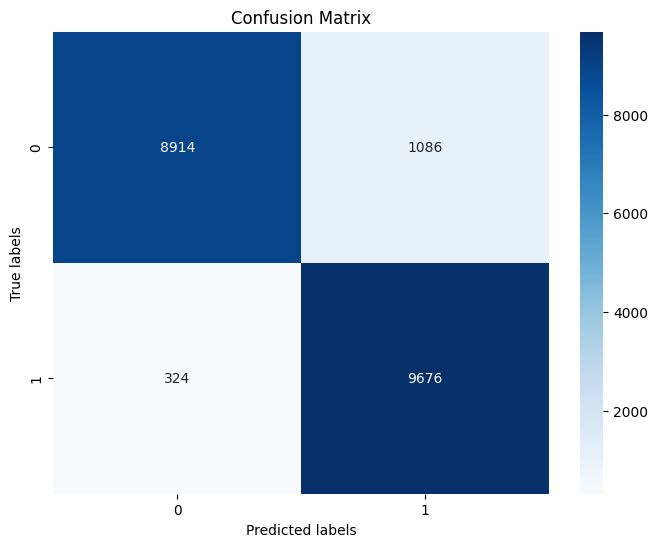

In [229]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [230]:
cm

array([[8914, 1086],
       [ 324, 9676]])

### 6. **Evaluation and Interpretation**

- **Feature Importance**: Check which features contribute most:

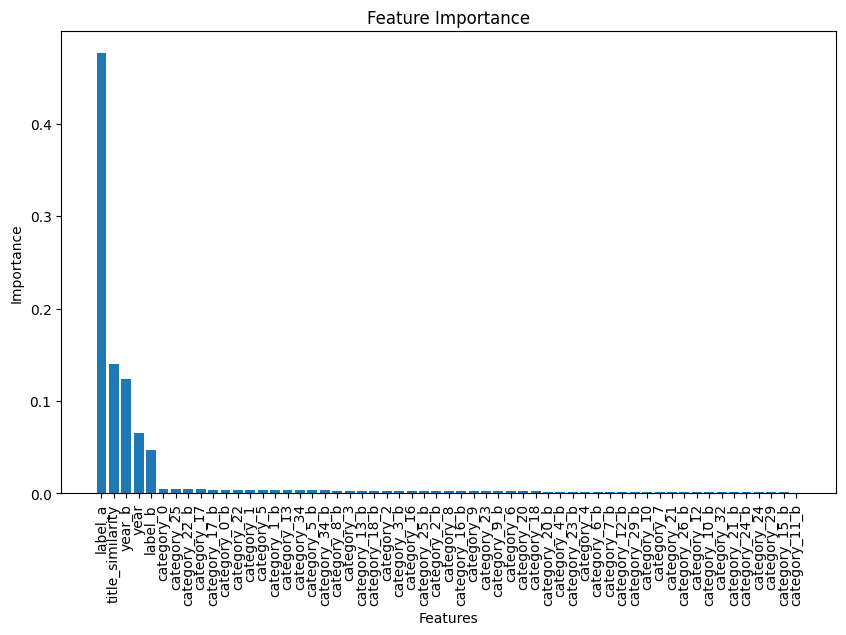

In [231]:
import matplotlib.pyplot as plt
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
selected_features = [X_train.columns[i] for i in indices if feature_importances[i] > 0.001]
selected_importances = [feature_importances[i] for i in indices if feature_importances[i] > 0.001]

plt.figure(figsize=(10, 6))
plt.bar(selected_features, selected_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [232]:
test_pairs_df

,paper_a,paper_b,label
0,413734,624808,1
1,451321,485424,0
2,84022,108333,0
3,300514,530093,1
4,76997,374102,1
...,...,...,...
19995,461019,181031,1
19996,345364,620780,1
19997,381284,39594,0
19998,550416,320912,1


In [233]:
train_pairs_df

,paper_a,paper_b,label
0,563462,311306,0
1,24,8161,0
2,138062,363780,0
3,469118,471134,0
4,354667,378469,0
...,...,...,...
99995,291220,350353,0
99996,87107,584454,1
99997,25859,325328,0
99998,497040,446168,1


In [234]:
assert len(set(train_df['index']).intersection(set(test_df['index']))) == 0, "Data leakage detected!"

In [238]:
def predict_citation_dynamic(test_pairs_df, df, clf, tfidf_vectorizer, X_train):
    # Randomly sample a row from test_pairs_df
    sampled_pair = test_pairs_df.sample(1).iloc[0]
    paper_a = sampled_pair['paper_a']
    paper_b = sampled_pair['paper_b']
    expected_label = sampled_pair['label']

    # Extract features for paper_a
    paper_a_data = df[df['index'] == paper_a].iloc[0]
    paper_a_features = paper_a_data.drop(['citations', 'index', 'title', 'abstract'])

    # Extract features for paper_b
    paper_b_data = df[df['index'] == paper_b].iloc[0]
    paper_b_features = paper_b_data.drop(['citations', 'index', 'title', 'abstract'])

    # Add suffix "_b" to paper_b features
    paper_b_features = paper_b_features.rename(lambda x: f"{x}_b")

    # Compute title similarity
    title_similarity = cosine_similarity(
        tfidf_vectorizer.transform([paper_a_data['title']]), 
        tfidf_vectorizer.transform([paper_b_data['title']])
    )[0][0]

    # Create the feature vector for both paper_a and paper_b
    feature_vector = {
        **paper_a_features.to_dict(),
        **paper_b_features.to_dict(),
        'title_similarity': title_similarity
    }

    # Ensure the feature vector is ordered the same way as the training data (X_train columns)
    feature_vector = {key: feature_vector.get(key, 0) for key in X_train.columns}

    # Prepare the final feature vector for prediction (convert to list of values)
    final_feature_vector = [float(value) for value in feature_vector.values()]

    # Convert to DataFrame to ensure proper alignment of feature names
    feature_df = pd.DataFrame([final_feature_vector], columns=X_train.columns)

    # Make prediction using the classifier
    prediction = clf.predict(feature_df)  # Pass the DataFrame with correct feature names

    # Print details for debugging
    print(f"Sampled pair: paper_a={paper_a}, paper_b={paper_b}")
    print(f"Expected Label: {expected_label}")
    print(f"Predicted Label: {prediction[0]}\n")

    # Return the result
    return prediction[0], expected_label

# Usage example:
# Sample 5 rows with label 1 and 5 with label 0
positive_samples = test_pairs_df[test_pairs_df['label'] == 1].sample(10)
negative_samples = test_pairs_df[test_pairs_df['label'] == 0].sample(10)
# Use pd.concat instead of append
sampled_test_pairs = pd.concat([positive_samples, negative_samples])

for _, row in sampled_test_pairs.iterrows():
    predicted_label, expected_label = predict_citation_dynamic(test_pairs_df, df, clf, tfidf_vectorizer, X_train)
    if predicted_label == expected_label:
        print("The prediction matches the expected label.")
    else:
        print("The prediction does not match the expected label.")


Sampled pair: paper_a=138738, paper_b=27280
Expected Label: 1
Predicted Label: 1

The prediction matches the expected label.
Sampled pair: paper_a=587736, paper_b=178121
Expected Label: 0
Predicted Label: 1

The prediction does not match the expected label.
Sampled pair: paper_a=352303, paper_b=296627
Expected Label: 1
Predicted Label: 1

The prediction matches the expected label.
Sampled pair: paper_a=571232, paper_b=94457
Expected Label: 1
Predicted Label: 1

The prediction matches the expected label.
Sampled pair: paper_a=6385, paper_b=436965
Expected Label: 0
Predicted Label: 0

The prediction matches the expected label.
Sampled pair: paper_a=615746, paper_b=423929
Expected Label: 0
Predicted Label: 1

The prediction does not match the expected label.
Sampled pair: paper_a=23215, paper_b=256810
Expected Label: 1
Predicted Label: 1

The prediction matches the expected label.
Sampled pair: paper_a=218455, paper_b=19153
Expected Label: 0
Predicted Label: 1

The prediction does not mat